In [34]:
from spherinator.data import ParquetDataModule

datamodule = ParquetDataModule(
    "/home/doserbd/data/gaia/xp_sampled_mean_spectrum/parquet",
    data_column="flux",
    batch_size=10,
    num_workers=1,
    shuffle=False,
)
datamodule.setup("fit")

batch = next(iter(datamodule.train_dataloader()))
batch.shape

torch.Size([10, 1, 344])

In [35]:
import wandb
run = wandb.init()
artifact = run.use_artifact('ain-space/gaia/model-tzmvobqh:v0', type='model')
artifact_dir = artifact.download()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bernddoser. Use `wandb login --relogin` to force relogin


wandb:   1 of 1 files downloaded.  


In [4]:
import torch
from spherinator.models import (
    ConvolutionalDecoder1D,
    ConvolutionalEncoder1D,
    AutoencoderPure,
)

encoder = ConvolutionalEncoder1D(input_dim=344, output_dim=3)
decoder = ConvolutionalDecoder1D(input_dim=3, output_dim=344)
model = AutoencoderPure(encoder=encoder, decoder=decoder)
model

ckpt = "artifacts/model-tzmvobqh:v0/model.ckpt"
checkpoint = torch.load(ckpt, weights_only=True, map_location="cpu")
model.load_state_dict(checkpoint["state_dict"])
model.eval()

print(model.encoder.enc1[0].bias)

recon = model(batch)

Parameter containing:
tensor([ 0.2796,  0.3690, -0.1307,  0.3560,  0.2470,  0.4342, -0.2837, -0.2462,
        -0.1438,  0.0259,  0.3003, -0.2846,  0.2523, -0.1792,  0.3011, -0.0216,
        -0.4449, -0.2747, -0.3612,  0.2491, -0.3354, -0.0405,  0.1088, -0.2705,
         0.1446, -0.4858, -0.3568, -0.4503, -0.1471, -0.1844,  0.0670, -0.0924],
       requires_grad=True)


/home/doserbd/.cache/pypoetry/virtualenvs/spherinator-zzYPp9oG-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
/home/doserbd/.cache/pypoetry/virtualenvs/spherinator-zzYPp9oG-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'decoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['decoder'])`.


NameError: name 'batch' is not defined

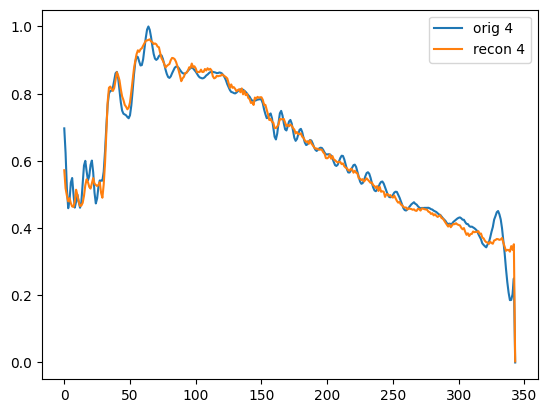

In [39]:
from matplotlib import pyplot as plt

id = 4
plt.figure()
plt.plot(batch[id][0].cpu().detach().numpy(), label=f"orig {id}")
plt.plot(recon[id][0].cpu().detach().numpy(), label=f"recon {id}")
plt.legend(loc="upper right")
plt.show()